# Product Matching between Zalando and Aboutyou: 
## CA684 Machine Learning Assignment 2022 

## Khizer Ahmed Biyabani

## 1. Loading the necessary libraries.

In [3]:
import pandas as pd
import numpy as np
from googletrans import Translator
translator = Translator(service_urls=['translate.googleapis.com'])

import re
import jellyfish as jf
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mpimg
from PIL import Image
import urllib

import time

import warnings
warnings.filterwarnings('ignore')

## 2. Loading the Data

In [4]:
offers_train_df = pd.read_parquet('offers_training.parquet')

In [5]:
offers_train_df.head()

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...
2,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...
3,556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...
4,48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...


In [6]:
#Checking the attributes

list(offers_train_df.columns)

['offer_id',
 'shop',
 'lang',
 'brand',
 'color',
 'title',
 'description',
 'price',
 'url',
 'image_urls']

In [7]:
offers_train_df.shape

(102884, 10)

In [8]:
pd.value_counts(offers_train_df['shop'], sort=True, ascending=False)

aboutyou    61980
zalando     40904
Name: shop, dtype: int64

## 3. Exploratory Data Analysis

In [9]:
#Checking the data_types

offers_train_df.dtypes

offer_id        object
shop            object
lang            object
brand           object
color           object
title           object
description     object
price          float64
url             object
image_urls      object
dtype: object

In [10]:
#Checking for null values

offers_train_df.isnull().sum()

offer_id        0
shop            0
lang            0
brand           0
color           2
title           0
description     0
price           2
url             0
image_urls     26
dtype: int64

In [11]:
#Treating the null values in color coloumn.

offers_train_df['color']=offers_train_df['color'].fillna("")

In [12]:
offers_train_df['color'].isnull().any()

False

In [13]:
#Function for None_type removal

def none_type_remove(stri):
    if stri == None:
        return ""
    else:
        return stri

offers_train_df['color']=offers_train_df['color'].apply(lambda x:none_type_remove(x))

## 4. Reading the Ground_Truth Matches

In [14]:
#Reading the matches data

match_df = pd.read_parquet('matches_training.parquet')

In [15]:
len(match_df)

15170

In [16]:
match_df.head(10)

,zalando,aboutyou,brand
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,10
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,10
5,86eab5f3-6254-4339-8abd-322a736c8824,4aae1500-274a-4ab0-b820-9ee88709f583,31
6,76ec7de0-f1f8-4ccf-ae87-f62b295dbfdf,b8a5f1eb-f85d-4509-bd28-52904f83803f,31
7,a91c95ab-8887-4f39-ade8-ed9d4217f670,68777769-75b9-4214-83a6-22b609d160d2,33
8,a549a54e-6742-4392-9d07-3696f885e3b4,a5e0929e-f273-40de-80ef-3b31f155c638,33
9,91893197-facc-45e5-87d6-afd472937eec,e420022c-5413-4498-a6a2-1ade58b77bc9,33


In [17]:
#Getting total unique brands 
brand_list = offers_train_df['brand'].unique()
len(brand_list)
# brand_list.head()

145

In [18]:
#Getting offers by brand. Function to separate both zalando and aboutyou offers brands.


def get_shops_for_brand(offers, brands):
    """ Get mapping for brands in between the two shops """
    
    mapping = {}
    for brand in brands:
        shops = offers[offers["brand"] == brand]["shop"].unique()
        for shop in shops:
            mapping.setdefault(shop, [])
            mapping[shop].append(brand)
#         print(f'Brand: "{brand}" is in {", ".join(shops)}')
    return mapping

In [19]:
mapping_shop_brand=get_shops_for_brand(offers_train_df,brand_list)

In [20]:
mapping_shop_brand['aboutyou'][1]

'LASCANA'

## 5. Separating the two shops

In [21]:
#Getting shop by brand. Function to separate both zalando and aboutyou offers.


def get_offers_by_shop(offers):
    """ Get offers per shop """   
    offers_zal = offers[(offers['shop'] == 'zalando')]
    offers_comp = offers[(offers['shop'] == 'aboutyou')]
    return offers_zal, offers_comp

In [22]:
offer_zal_train, offer_abtyou_train = get_offers_by_shop(offers_train_df)

In [23]:
#Changing the index to zalando offer id.


offer_zal_train = offer_zal_train.set_index('offer_id')
offer_zal_train.head()

,shop,lang,brand,color,title,description,price,url,image_urls
offer_id,,,,,,,,,
02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,zalando,de,Guess,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,skirt_details Eingrifftaschen | Ziersteine $ n...,150.685455,https://www.zalando.de/lookup/article/GU123L05...,[https://img01.ztat.net/article/1ec35ff491c54e...
08c47691-4160-41df-81c5-ea108f2ae539,zalando,de,Ellesse,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,name_suffix white $ pattern print $ material.u...,39.958182,https://www.zalando.de/lookup/article/EL981P00...,[https://img01.ztat.net/article/511a8191c10549...
96fc5065-3a31-42f0-bfbd-34ee94324807,zalando,de,Selected,blau,SLHSLIMMARK WASHED Businesshemd,main_supplier_code K70240 $ name_suffix dark s...,39.990909,https://www.zalando.de/lookup/article/SE622D0Y...,[https://img01.ztat.net/article/4ca1292819fa35...
04341c9e-4043-4478-9a64-266ac38480b5,zalando,de,Ellesse,schwarz,NURRA FASHION TRUNKS 5 PACK Panties,main_supplier_code K10441 $ name_suffix black ...,32.958182,https://www.zalando.de/lookup/article/EL982O00...,[https://img01.ztat.net/article/ca67693a608332...
346abc38-d9ae-431a-8e6a-64f7bb3ade7e,zalando,de,Selected,braun,SLFOLIVE CARDIGAN Strickjacke,name_suffix carafe $ pattern meliert $ materia...,89.990909,https://www.zalando.de/lookup/article/SE521I0P...,[https://img01.ztat.net/article/a797f668349e4d...


In [24]:
#Just checking a color of an offer.

offer_zal_train.loc['b33f55d6-0149-4063-8b63-3eeae63562a2']['color']

'silberfarben'

In [25]:
#Changing the index to aboutyou offer id.

offer_abtyou_train=offer_abtyou_train.set_index('offer_id')
offer_abtyou_train.head()

,shop,lang,brand,color,title,description,price,url,image_urls
offer_id,,,,,,,,,
d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...
f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...
556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...
48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...


In [26]:
offer_abtyou_train.loc['ad5ceb87-0254-4171-b650-1d4d09f48efc']['url']

'https://www.aboutyou.de/p/swarovski/kette-4364831'

In [27]:
#Creating a new_data frame with only offer_ids from matched data of both the shops.

new_data = pd.DataFrame()

In [28]:
new_data['zalando'] = pd.DataFrame(match_df['zalando'])
new_data['aboutyou'] = pd.DataFrame(match_df['aboutyou'])

## 6. Preparing Training set with match and unmatched values.

In [29]:
#getting list of colors, title and description values for zalando.

zal_color = []
zal_title = []
zal_desc = []
#zal_price = []
for index in new_data['zalando']:
    for ids in offer_zal_train.index:
        if index == ids:
            zal_color.append(offer_zal_train.loc[ids]['color'])
            zal_title.append(offer_zal_train.loc[ids]['title'])
            zal_desc.append(offer_zal_train.loc[ids]['description'])
            zal_price.append(offer_zal_train.loc[ids]['price'])

In [30]:
#getting list of colors, title and description values  for aboutyou.


abtyou_color = []
abtyou_title = []
abtyou_desc = []
# abtyou_price = []
for index in new_data['aboutyou']:
    for ids in offer_abtyou_train.index:
        if index == ids:
            abtyou_color.append(offer_abtyou_train.loc[ids]['color'])
            abtyou_title.append(offer_abtyou_train.loc[ids]['title'])
            abtyou_desc.append(offer_abtyou_train.loc[ids]['description'])
#             abtyou_price.append(offer_abtyou_train.loc[ids]['price'])

In [31]:
#Adding the color, title and description to the matched offers.

new_data['zalando_color'],new_data['aboutyou_color'],new_data['zalando_title'],new_data['aboutyou_title'],new_data['zalando_description'],new_data['aboutyou_description']= zal_color,abtyou_color, zal_title, abtyou_title, zal_desc, abtyou_desc
new_data.head()

,zalando,aboutyou,zalando_color,aboutyou_color,zalando_title,aboutyou_title,zalando_description,aboutyou_description
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,silberfarben,silber | weiß | Silber,CREATIVITY Halskette,Kette,main_supplier_code K85009 $ name_suffix silver...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz..."
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,roségoldfarben,rosegold | Gold,LIFELONG BANGLE Armband,Armreif,main_supplier_code K85009 $ name_suffix rosego...,"{""Gr\u00f6\u00dfe"": [""Unisex - Intern. Accesso..."
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,silberfarben,rosegold | silber | Silber,ETERNAL FLOWER BANGLE FLY Armband,Armreif 'Eternal Flower',main_supplier_code K85009 $ name_suffix fancy ...,"{""Gr\u00f6\u00dfe"": [""Unisex - Schmuck intern...."
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,silberfarben,silber | Silber,ANGELIC BRACELET Armband,Armband,main_supplier_code K85009 $ name_suffix crysta...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz..."
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,weiß,weiß | rosegold | Gold,CONSTELLA BANGLE Armband,Armband,main_supplier_code K85009 $ name_suffix rosego...,"{""Schmuckart"": [""Modeschmuck""], ""Suchfarbe"": [..."


In [32]:
new_data['match'] = 1

In [33]:
new_data.head(20)

,zalando,aboutyou,zalando_color,aboutyou_color,zalando_title,aboutyou_title,zalando_description,aboutyou_description,match
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,silberfarben,silber | weiß | Silber,CREATIVITY Halskette,Kette,main_supplier_code K85009 $ name_suffix silver...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz...",1
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,roségoldfarben,rosegold | Gold,LIFELONG BANGLE Armband,Armreif,main_supplier_code K85009 $ name_suffix rosego...,"{""Gr\u00f6\u00dfe"": [""Unisex - Intern. Accesso...",1
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,silberfarben,rosegold | silber | Silber,ETERNAL FLOWER BANGLE FLY Armband,Armreif 'Eternal Flower',main_supplier_code K85009 $ name_suffix fancy ...,"{""Gr\u00f6\u00dfe"": [""Unisex - Schmuck intern....",1
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,silberfarben,silber | Silber,ANGELIC BRACELET Armband,Armband,main_supplier_code K85009 $ name_suffix crysta...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz...",1
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,weiß,weiß | rosegold | Gold,CONSTELLA BANGLE Armband,Armband,main_supplier_code K85009 $ name_suffix rosego...,"{""Schmuckart"": [""Modeschmuck""], ""Suchfarbe"": [...",1
5,86eab5f3-6254-4339-8abd-322a736c8824,4aae1500-274a-4ab0-b820-9ee88709f583,cognac,cognac | Braun,Schnürstiefelette,Schnürboots,main_supplier_code K71979 $ decksohle Lederimi...,"{""Zielgruppe"": [""Male""], ""Material"": [""Glattle...",1
6,76ec7de0-f1f8-4ccf-ae87-f62b295dbfdf,b8a5f1eb-f85d-4509-bd28-52904f83803f,cognac,karamell | weiß | dunkelblau | Braun,Sneaker low,Sneaker,main_supplier_code K71979 $ decksohle Leder $ ...,"{""Material"": [""Glattleder""], ""Sneaker-Stil"": [...",1
7,a91c95ab-8887-4f39-ade8-ed9d4217f670,68777769-75b9-4214-83a6-22b609d160d2,schwarz,braun | schwarz | Schwarz,Sonnenbrille,Sonnenbrille '0BE4299',lens_tint Dunkel (Filterkategorie 3) $ main_su...,"{""Detailfarbe"": [""braun"", ""schwarz""], ""Suchfar...",1
8,a549a54e-6742-4392-9d07-3696f885e3b4,a5e0929e-f273-40de-80ef-3b31f155c638,braun,braun | Braun,Sonnenbrille,Sonnenbrille '0BE4327',lens_tint Mittel (Filterkategorie 2) $ main_su...,"{""Zielgruppe"": [""Female""], ""Marke"": [""BURBERRY...",1
9,91893197-facc-45e5-87d6-afd472937eec,e420022c-5413-4498-a6a2-1ade58b77bc9,goldfarben,gold | dunkelgrau | Gold,UNISEX Sonnenbrille,Sonnenbrille 'DEAN',lens_tint Mittel (Filterkategorie 2) $ main_su...,"{""Zielgruppe"": [""Female""], ""Marke"": [""BURBERRY...",1


In [34]:
# new_data['zalando_color']= new_data['zalando_color'].apply(lambda s:s.lower() if type(s) == str else s)
# new_data['zalando_title']= new_data['zalando_title'].apply(lambda s:s.lower() if type(s) == str else s)
# new_data['zalando_description']= new_data['zalando_description'].apply(lambda s:s.lower() if type(s) == str else s)
# new_data['aboutyou_color']= new_data['aboutyou_color'].apply(lambda s:s.lower() if type(s) == str else s)
# new_data['aboutyou_title']= new_data['aboutyou_title'].apply(lambda s:s.lower() if type(s) == str else s)
# new_data['aboutyou_description']= new_data['aboutyou_description'].apply(lambda s:s.lower() if type(s) == str else s)

In [35]:
# new_data['zalando_color'] = new_data['zalando_color'].apply(translator.translate, src='de', dest='en').apply(getattr, args=('text',))
# new_data['zalando_description'] = new_data['zalando_description'].apply(translator.translate, src='de', dest='en').apply(getattr, args=('text',))

In [36]:
# count = 0
# for i in new_data['aboutyou_color']:
#     new_data['aboutyou_color'][count] = translator.translate(i)
#     count=count+1
    

In [37]:
# new_data['aboutyou_color']=new_data['aboutyou_color'].apply(lambda x : x.text)

In [38]:
# count = 0
# for i in new_data['aboutyou_title']:
#     new_data['aboutyou_title'][count] = translator.translate(i)
#     count=count+1
# new_data['aboutyou_title']=new_data['aboutyou_title'].apply(lambda x : x.text)

# count = 0
# for i in new_data['zalando_title']:
#     new_data['zalando_title'][count] = translator.translate(i)
#     count=count+1
# new_data['zalando_title']=new_data['zalando_title'].apply(lambda x : x.text)

# count = 0
# for i in new_data['aboutyou_description']:
#     new_data['aboutyou_description'][count] = translator.translate(i)
#     count=count+1
# new_data['aboutyou_description']=new_data['aboutyou_description'].apply(lambda x : x.text)

In [39]:
# %store -r new_data

In [40]:
# new_data_translated = new_data
# %store new_data_translated

In [41]:
new_data.head()

,zalando,aboutyou,zalando_color,aboutyou_color,zalando_title,aboutyou_title,zalando_description,aboutyou_description,match
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,silberfarben,silber | weiß | Silber,CREATIVITY Halskette,Kette,main_supplier_code K85009 $ name_suffix silver...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz...",1
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,roségoldfarben,rosegold | Gold,LIFELONG BANGLE Armband,Armreif,main_supplier_code K85009 $ name_suffix rosego...,"{""Gr\u00f6\u00dfe"": [""Unisex - Intern. Accesso...",1
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,silberfarben,rosegold | silber | Silber,ETERNAL FLOWER BANGLE FLY Armband,Armreif 'Eternal Flower',main_supplier_code K85009 $ name_suffix fancy ...,"{""Gr\u00f6\u00dfe"": [""Unisex - Schmuck intern....",1
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,silberfarben,silber | Silber,ANGELIC BRACELET Armband,Armband,main_supplier_code K85009 $ name_suffix crysta...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz...",1
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,weiß,weiß | rosegold | Gold,CONSTELLA BANGLE Armband,Armband,main_supplier_code K85009 $ name_suffix rosego...,"{""Schmuckart"": [""Modeschmuck""], ""Suchfarbe"": [...",1


### The unmatched offers from training set 

In [42]:
#Getting the unmatched offers

new_unmatched_zal = []
for i in offer_zal_train.index:
    if i not in offers_train_df['offer_id']:
        new_unmatched_zal.append(i)
        
new_unmatched_abtyou = []
for i in offer_zal_train.index:
    if i not in offers_train_df['offer_id']:
        new_unmatched_abtyou.append(i)

In [43]:
#Getting the unmatched offers by simply dropping matched offers.

zal_unmatched_train = offer_zal_train.drop(match_df['zalando'])
abtyou_unmatched_train = offer_abtyou_train.drop(match_df['aboutyou'])

In [44]:
zal_unmatched_train.head() 
abtyou_unmatched_train.head()

,shop,lang,brand,color,title,description,price,url,image_urls
offer_id,,,,,,,,,
d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...
f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...
556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...
48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...


In [45]:
zal_unmatched_train=zal_unmatched_train.reset_index()
abtyou_unmatched_train=abtyou_unmatched_train.reset_index()

In [46]:
#joining the random unmatched offers from aboutyou and zalando.

offer_unmatched = zal_unmatched_train.join(abtyou_unmatched_train, lsuffix="_zal", rsuffix="_abtyou")
offer_unmatched.head()

,offer_id_zal,shop_zal,lang_zal,brand_zal,color_zal,title_zal,description_zal,price_zal,url_zal,image_urls_zal,offer_id_abtyou,shop_abtyou,lang_abtyou,brand_abtyou,color_abtyou,title_abtyou,description_abtyou,price_abtyou,url_abtyou,image_urls_abtyou
0,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,zalando,de,Guess,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,skirt_details Eingrifftaschen | Ziersteine $ n...,150.685455,https://www.zalando.de/lookup/article/GU123L05...,[https://img01.ztat.net/article/1ec35ff491c54e...,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
1,08c47691-4160-41df-81c5-ea108f2ae539,zalando,de,Ellesse,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,name_suffix white $ pattern print $ material.u...,39.958182,https://www.zalando.de/lookup/article/EL981P00...,[https://img01.ztat.net/article/511a8191c10549...,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...
2,96fc5065-3a31-42f0-bfbd-34ee94324807,zalando,de,Selected,blau,SLHSLIMMARK WASHED Businesshemd,main_supplier_code K70240 $ name_suffix dark s...,39.990909,https://www.zalando.de/lookup/article/SE622D0Y...,[https://img01.ztat.net/article/4ca1292819fa35...,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...
3,04341c9e-4043-4478-9a64-266ac38480b5,zalando,de,Ellesse,schwarz,NURRA FASHION TRUNKS 5 PACK Panties,main_supplier_code K10441 $ name_suffix black ...,32.958182,https://www.zalando.de/lookup/article/EL982O00...,[https://img01.ztat.net/article/ca67693a608332...,556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...
4,579f4b76-2361-4d2d-9d9a-1190c46e4001,zalando,de,Kaffe,oliv,KAMONNA BLOUSE Langarmshirt Bluse,main_supplier_code K73264 $ skirt_details elas...,49.958182,https://www.zalando.de/lookup/article/KA321E0T...,[https://img01.ztat.net/article/1bf8841d9c4d32...,48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...


In [47]:
#Dropping of the unnecessary columns.

offer_unmatched = offer_unmatched.drop(['image_urls_abtyou','url_abtyou','lang_zal','shop_zal','brand_zal','brand_abtyou','shop_abtyou' ,'lang_abtyou','image_urls_zal','url_zal','price_zal','price_abtyou'],axis=1)

In [48]:
offer_unmatched.head()

,offer_id_zal,color_zal,title_zal,description_zal,offer_id_abtyou,color_abtyou,title_abtyou,description_abtyou
0,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,skirt_details Eingrifftaschen | Ziersteine $ n...,d8e0dba8-98e8-48db-9850-dd30cff374e0,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4..."
1,08c47691-4160-41df-81c5-ea108f2ae539,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,name_suffix white $ pattern print $ material.u...,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""..."
2,96fc5065-3a31-42f0-bfbd-34ee94324807,blau,SLHSLIMMARK WASHED Businesshemd,main_supplier_code K70240 $ name_suffix dark s...,f0328791-9839-4bc1-ac62-78b7515e9601,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla..."
3,04341c9e-4043-4478-9a64-266ac38480b5,schwarz,NURRA FASHION TRUNKS 5 PACK Panties,main_supplier_code K10441 $ name_suffix black ...,556e8f61-b1d7-4d72-8bae-d74f9357270b,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal..."
4,579f4b76-2361-4d2d-9d9a-1190c46e4001,oliv,KAMONNA BLOUSE Langarmshirt Bluse,main_supplier_code K73264 $ skirt_details elas...,48b32330-0a6e-4c10-9ef5-c585ac6da701,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn..."


In [49]:
#Making the attributes of unmatched offers same as matched.

offer_unmatched=offer_unmatched.rename(
    columns={'offer_id_zal':'zalando','offer_id_abtyou':'aboutyou',
             'title_zal':'zalando_title','title_abtyou':'aboutyou_title',
             'color_zal':'zalando_color','color_abtyou':'aboutyou_color',
             'description_zal':'zalando_description','description_abtyou':'aboutyou_description',
             'offer_id_abtyou':'aboutyou'})

In [50]:
offer_unmatched['match']=0

In [51]:
offer_unmatched.head()

,zalando,zalando_color,zalando_title,zalando_description,aboutyou,aboutyou_color,aboutyou_title,aboutyou_description,match
0,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,skirt_details Eingrifftaschen | Ziersteine $ n...,d8e0dba8-98e8-48db-9850-dd30cff374e0,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",0
1,08c47691-4160-41df-81c5-ea108f2ae539,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,name_suffix white $ pattern print $ material.u...,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",0
2,96fc5065-3a31-42f0-bfbd-34ee94324807,blau,SLHSLIMMARK WASHED Businesshemd,main_supplier_code K70240 $ name_suffix dark s...,f0328791-9839-4bc1-ac62-78b7515e9601,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",0
3,04341c9e-4043-4478-9a64-266ac38480b5,schwarz,NURRA FASHION TRUNKS 5 PACK Panties,main_supplier_code K10441 $ name_suffix black ...,556e8f61-b1d7-4d72-8bae-d74f9357270b,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",0
4,579f4b76-2361-4d2d-9d9a-1190c46e4001,oliv,KAMONNA BLOUSE Langarmshirt Bluse,main_supplier_code K73264 $ skirt_details elas...,48b32330-0a6e-4c10-9ef5-c585ac6da701,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",0


In [52]:
offer_unmatched.shape

(25734, 9)

In [53]:
#Adding the non matches with the matched to create the final training data containing matche = 1 and not match =0.

offer_data_train = pd.concat([new_data, offer_unmatched])

In [54]:
offer_data_train.head()

,zalando,aboutyou,zalando_color,aboutyou_color,zalando_title,aboutyou_title,zalando_description,aboutyou_description,match
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,silberfarben,silber | weiß | Silber,CREATIVITY Halskette,Kette,main_supplier_code K85009 $ name_suffix silver...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz...",1
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,roségoldfarben,rosegold | Gold,LIFELONG BANGLE Armband,Armreif,main_supplier_code K85009 $ name_suffix rosego...,"{""Gr\u00f6\u00dfe"": [""Unisex - Intern. Accesso...",1
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,silberfarben,rosegold | silber | Silber,ETERNAL FLOWER BANGLE FLY Armband,Armreif 'Eternal Flower',main_supplier_code K85009 $ name_suffix fancy ...,"{""Gr\u00f6\u00dfe"": [""Unisex - Schmuck intern....",1
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,silberfarben,silber | Silber,ANGELIC BRACELET Armband,Armband,main_supplier_code K85009 $ name_suffix crysta...,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesiz...",1
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,weiß,weiß | rosegold | Gold,CONSTELLA BANGLE Armband,Armband,main_supplier_code K85009 $ name_suffix rosego...,"{""Schmuckart"": [""Modeschmuck""], ""Suchfarbe"": [...",1


In [55]:
offer_data_train = offer_data_train.sample(frac=1)

In [56]:
offer_data_train.head()

,zalando,aboutyou,zalando_color,aboutyou_color,zalando_title,aboutyou_title,zalando_description,aboutyou_description,match
12404,23841240-b777-4bc1-b477-b582431c924e,cdde8874-30fc-49a8-b176-c03ec21f3914,grün,grün | Grün,VMANA Bluse Top,Top 'VMANA',main_supplier_code K70240 $ name_suffix desert...,"{""\u00c4rmell\u00e4nge"": [""\u00c4rmellos""], ""L...",1
19836,5d26a4a3-1504-4207-8584-207b102e7a59,6e857a05-b598-4ff4-aa0f-fd677386a588,schwarz,apricot | Orange,MAKENZIE Riemensandalette Brautschuh,Langarm-Bluse,main_supplier_code K11495 $ decksohle Lederimi...,"{""Marke"": [""Kaffe""], ""Gr\u00f6\u00dfenlauf"": [...",0
5693,8a42d6a9-24f6-43ac-9a01-99d2fa80acf5,01f0f67d-f97c-4629-b341-ca298a015970,grün,braun | Braun,WIND JACKET Trainingsjacke,Stoffhose,main_supplier_code K85347 $ sport_jacket_detai...,"{""Marke"": [""Dockers""], ""Gr\u00f6\u00dfenlauf"":...",0
1214,7340b0c0-0133-42d2-8560-7194092dd98f,4ad3024b-862c-4fcd-9337-abd827922aa7,dunkelblau,dunkelpink | Pink,DEMBI PANT Jogginghose,Bügel-Bandeau-Bikini,main_supplier_code K10441 $ skirt_details elas...,"{""Gr\u00f6\u00dfe"": [""def_female_int""], ""Order...",0
22680,f56fb0e2-2b29-47db-be64-ef3803c2ab92,8510c52a-f084-4f69-9638-9a82d95dff05,schwarz,türkis | goldgelb | Blau,KAKITLYN Strickpullover,T-Shirt 'DANNY',main_supplier_code K73264 $ name_suffix black ...,"{""Zielgruppe"": [""Male""], ""Material"": [""Jersey""...",0


In [57]:
offer_data_train.shape

(40904, 9)

In [58]:
offer_data_train['match'].value_counts()

0    25734
1    15170
Name: match, dtype: int64

## 7. Checking the text Similarity 

Applyig different similarity measures 

In [59]:
#Function for any matching numbers.

def matching_numbers(abtyou_name, zal_name):

    abtyou_numbers = set(re.findall(r'[0-9]+', abtyou_name))
    zal_numbers = set(re.findall(r'[0-9]+', zal_name))    
    union = abtyou_numbers.union(zal_numbers)
    intersection = abtyou_numbers.intersection(zal_numbers)

    if len(abtyou_numbers)==0 and len(zal_numbers) == 0:
        return 1
    else:
        return (len(intersection)/ len(union))


In [60]:
#Function for offer title matching.

def engineer_features_title(df):

    df['zalando_title'] = df['zalando_title'].str.lower()
    df['aboutyou_title'] = df['aboutyou_title'].str.lower()
    

    
#     df['zalando_color'] = df['zalando_color'].str.lower()
#     df['aboutyou_color'] = df['aboutyou_color'].str.lower()
    
#     df['zal_description'] = df['zal_description'].str.lower()
#     df['aboutyou_description'] = df['aboutyou_descriptionr'].str.lower()

    df['title_levenshtein_distance'] = df.apply(
    lambda x: jf.levenshtein_distance(x['aboutyou_title'], 
                                      x['zalando_title']), axis=1)

    df['title_damerau_levenshtein_distance'] = df.apply(
    lambda x: jf.damerau_levenshtein_distance(x['aboutyou_title'], 
                                              x['zalando_title']), axis=1)

    df['title_hamming_distance'] = df.apply(
    lambda x: jf.hamming_distance(x['aboutyou_title'], 
                                  x['zalando_title']), axis=1)

    df['title_jaro_similarity'] = df.apply(
    lambda x: jf.jaro_similarity(x['aboutyou_title'], 
                                  x['zalando_title']), axis=1)

    df['title_jaro_winkler_similarity'] = df.apply(
    lambda x: jf.jaro_winkler_similarity(x['aboutyou_title'], 
                                         x['zalando_title']), axis=1)

    df['title_match_rating_comparison'] = df.apply(
    lambda x: jf.match_rating_comparison(x['aboutyou_title'], 
                                         x['zalando_title']), axis=1).fillna(0).astype(int)

    df['title_fuzz_ratio'] = df.apply(
    lambda x: fuzz.ratio(x['aboutyou_title'], 
                         x['zalando_title']), axis=1)

    df['title_partial_ratio'] = df.apply(
    lambda x: fuzz.partial_ratio(x['aboutyou_title'], 
                                 x['zalando_title']), axis=1)

    df['title_token_sort_ratio'] = df.apply(
    lambda x: fuzz.token_sort_ratio(x['aboutyou_title'], 
                                    x['zalando_title']), axis=1)

    df['title_token_set_ratio'] = df.apply(
    lambda x: fuzz.token_set_ratio(x['aboutyou_title'], 
                                   x['zalando_title']), axis=1)

    df['title_w_ratio'] = df.apply(
    lambda x: fuzz.WRatio(x['aboutyou_title'], 
                          x['zalando_title']), axis=1)

    df['title_uq_ratio'] = df.apply(
    lambda x: fuzz.UQRatio(x['aboutyou_title'], 
                          x['zalando_title']), axis=1)

    df['title_q_ratio'] = df.apply(
    lambda x: fuzz.QRatio(x['aboutyou_title'], 
                          x['zalando_title']), axis=1)    

    df['title_matching_numbers'] = df.apply(
    lambda x: matching_numbers(x['aboutyou_title'], 
                               x['zalando_title']), axis=1)

    df['title_matching_numbers_log'] = (df['title_matching_numbers']+1).apply(np.log)

    df['title_log_fuzz_score'] = (df['title_fuzz_ratio'] + df['title_partial_ratio'] + 
                            df['title_token_sort_ratio'] + df['title_token_set_ratio']).apply(np.log)

    df['title_log_fuzz_score_numbers'] = df['title_log_fuzz_score'] + (df['title_matching_numbers']).apply(np.log)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(value=0, inplace=True)

    return df


In [61]:
#Function for offer color matching.

def engineer_features_color(df):

    df['zalando_color'] = df['zalando_color'].str.lower()
    df['aboutyou_color'] = df['aboutyou_color'].str.lower()
    
    df['aboutyou_color'] = df['aboutyou_color'].apply(lambda x : x.replace(' |',''))
    
    df['color_levenshtein_distance'] = df.apply(
    lambda x: jf.levenshtein_distance(x['aboutyou_color'], 
                                      x['zalando_color']), axis=1)

    df['color_damerau_levenshtein_distance'] = df.apply(
    lambda x: jf.damerau_levenshtein_distance(x['aboutyou_color'], 
                                              x['zalando_color']), axis=1)

    df['color_hamming_distance'] = df.apply(
    lambda x: jf.hamming_distance(x['aboutyou_color'], 
                                  x['zalando_color']), axis=1)

    df['color_jaro_similarity'] = df.apply(
    lambda x: jf.jaro_similarity(x['aboutyou_color'], 
                                  x['zalando_color']), axis=1)

    df['color_jaro_winkler_similarity'] = df.apply(
    lambda x: jf.jaro_winkler_similarity(x['aboutyou_color'], 
                                         x['zalando_color']), axis=1)

    df['color_match_rating_comparison'] = df.apply(
    lambda x: jf.match_rating_comparison(x['aboutyou_color'], 
                                         x['zalando_color']), axis=1).fillna(0).astype(int)

    df['color_fuzz_ratio'] = df.apply(
    lambda x: fuzz.ratio(x['aboutyou_color'], 
                         x['zalando_color']), axis=1)

    df['color_partial_ratio'] = df.apply(
    lambda x: fuzz.partial_ratio(x['aboutyou_color'], 
                                 x['zalando_color']), axis=1)

    df['color_token_sort_ratio'] = df.apply(
    lambda x: fuzz.token_sort_ratio(x['aboutyou_color'], 
                                    x['zalando_color']), axis=1)

    df['color_token_set_ratio'] = df.apply(
    lambda x: fuzz.token_set_ratio(x['aboutyou_color'], 
                                   x['zalando_color']), axis=1)

    df['color_w_ratio'] = df.apply(
    lambda x: fuzz.WRatio(x['aboutyou_color'], 
                          x['zalando_color']), axis=1)

    df['color_uq_ratio'] = df.apply(
    lambda x: fuzz.UQRatio(x['aboutyou_color'], 
                          x['zalando_color']), axis=1)

    df['color_q_ratio'] = df.apply(
    lambda x: fuzz.QRatio(x['aboutyou_color'], 
                          x['zalando_color']), axis=1)    

    df['color_matching_numbers'] = df.apply(
    lambda x: matching_numbers(x['aboutyou_color'], 
                               x['zalando_color']), axis=1)

    df['color_matching_numbers_log'] = (df['color_matching_numbers']+1).apply(np.log)

    df['color_log_fuzz_score'] = (df['color_fuzz_ratio'] + df['color_partial_ratio'] + 
                            df['color_token_sort_ratio'] + df['color_token_set_ratio']).apply(np.log)

    df['color_log_fuzz_score_numbers'] = df['color_log_fuzz_score'] + (df['color_matching_numbers']).apply(np.log)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(value=0, inplace=True)

    return df


In [62]:
#Function for offer description matching.

def engineer_features_description(df):

    df['zalando_description'] = df['zalando_description'].str.lower()
    df['aboutyou_description'] = df['aboutyou_description'].str.lower()

    df['description_levenshtein_distance'] = df.apply(
    lambda x: jf.levenshtein_distance(x['aboutyou_description'], 
                                      x['zalando_description']), axis=1)

    df['description_damerau_levenshtein_distance'] = df.apply(
    lambda x: jf.damerau_levenshtein_distance(x['aboutyou_description'], 
                                              x['zalando_description']), axis=1)

    df['description_hamming_distance'] = df.apply(
    lambda x: jf.hamming_distance(x['aboutyou_description'], 
                                  x['zalando_description']), axis=1)

    df['description_jaro_similarity'] = df.apply(
    lambda x: jf.jaro_similarity(x['aboutyou_description'], 
                                  x['zalando_description']), axis=1)

    df['description_jaro_winkler_similarity'] = df.apply(
    lambda x: jf.jaro_winkler_similarity(x['aboutyou_description'], 
                                         x['zalando_description']), axis=1)

    df['description_match_rating_comparison'] = df.apply(
    lambda x: jf.match_rating_comparison(x['aboutyou_description'], 
                                         x['zalando_description']), axis=1).fillna(0).astype(int)

    df['description_fuzz_ratio'] = df.apply(
    lambda x: fuzz.ratio(x['aboutyou_description'], 
                         x['zalando_description']), axis=1)

    df['description_partial_ratio'] = df.apply(
    lambda x: fuzz.partial_ratio(x['aboutyou_description'], 
                                 x['zalando_description']), axis=1)

    df['description_token_sort_ratio'] = df.apply(
    lambda x: fuzz.token_sort_ratio(x['aboutyou_description'], 
                                    x['zalando_description']), axis=1)

    df['description_token_set_ratio'] = df.apply(
    lambda x: fuzz.token_set_ratio(x['aboutyou_description'], 
                                   x['zalando_description']), axis=1)

    df['description_w_ratio'] = df.apply(
    lambda x: fuzz.WRatio(x['aboutyou_description'], 
                          x['zalando_description']), axis=1)

    df['description_uq_ratio'] = df.apply(
    lambda x: fuzz.UQRatio(x['aboutyou_description'], 
                          x['zalando_description']), axis=1)

    df['description_q_ratio'] = df.apply(
    lambda x: fuzz.QRatio(x['aboutyou_description'], 
                          x['zalando_description']), axis=1)    

    df['description_matching_numbers'] = df.apply(
    lambda x: matching_numbers(x['aboutyou_description'], 
                               x['zalando_description']), axis=1)

    df['description_matching_numbers_log'] = (df['description_matching_numbers']+1).apply(np.log)

    df['description_log_fuzz_score'] = (df['description_fuzz_ratio'] + df['description_partial_ratio'] + 
                            df['description_token_sort_ratio'] + df['description_token_set_ratio']).apply(np.log)

    df['description_log_fuzz_score_numbers'] = df['description_log_fuzz_score'] + (df['description_matching_numbers']).apply(np.log)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(value=0, inplace=True)

    return df


### Getting the color, title and description similarity score for both the shops.

In [63]:
#Calculating the color similarity.

df = engineer_features_color(offer_data_train)

In [65]:
#Calculating the description similarity.

df = engineer_features_description(offer_data_train)

In [66]:
#Calculating the title similarity.

df = engineer_features_title(offer_data_train)

In [67]:
df = df.set_index('zalando')
df = df.reset_index()

In [149]:
df.head()

,zalando,aboutyou,zalando_color,aboutyou_color,zalando_title,aboutyou_title,zalando_description,aboutyou_description,match,color_levenshtein_distance,...,title_partial_ratio,title_token_sort_ratio,title_token_set_ratio,title_w_ratio,title_uq_ratio,title_q_ratio,title_matching_numbers,title_matching_numbers_log,title_log_fuzz_score,title_log_fuzz_score_numbers
0,23841240-b777-4bc1-b477-b582431c924e,cdde8874-30fc-49a8-b176-c03ec21f3914,grün,grün grün,vmana bluse top,top 'vmana',main_supplier_code k70240 $ name_suffix desert...,"{""\u00c4rmell\u00e4nge"": [""\u00c4rmellos""], ""l...",1,5,...,45,75,100,86,40,40,1.0,0.693147,5.552960,5.552960
1,5d26a4a3-1504-4207-8584-207b102e7a59,6e857a05-b598-4ff4-aa0f-fd677386a588,schwarz,apricot orange,makenzie riemensandalette brautschuh,langarm-bluse,main_supplier_code k11495 $ decksohle lederimi...,"{""marke"": [""kaffe""], ""gr\u00f6\u00dfenlauf"": [...",0,12,...,31,33,33,34,29,29,1.0,0.693147,4.795791,4.795791
2,8a42d6a9-24f6-43ac-9a01-99d2fa80acf5,01f0f67d-f97c-4629-b341-ca298a015970,grün,braun braun,wind jacket trainingsjacke,stoffhose,main_supplier_code k85347 $ sport_jacket_detai...,"{""marke"": [""dockers""], ""gr\u00f6\u00dfenlauf"":...",0,9,...,27,11,11,24,11,11,1.0,0.693147,4.094345,4.094345
3,7340b0c0-0133-42d2-8560-7194092dd98f,4ad3024b-862c-4fcd-9337-abd827922aa7,dunkelblau,dunkelpink pink,dembi pant jogginghose,bügel-bandeau-bikini,main_supplier_code k10441 $ skirt_details elas...,"{""gr\u00f6\u00dfe"": [""def_female_int""], ""order...",0,9,...,26,15,15,34,33,34,1.0,0.693147,4.382027,4.382027
4,f56fb0e2-2b29-47db-be64-ef3803c2ab92,8510c52a-f084-4f69-9638-9a82d95dff05,schwarz,türkis goldgelb blau,kakitlyn strickpullover,t-shirt 'danny',main_supplier_code k73264 $ name_suffix black ...,"{""zielgruppe"": [""male""], ""material"": [""jersey""...",0,19,...,20,33,33,32,26,26,1.0,0.693147,4.672829,4.672829


In [68]:
#To save time we have stored the dataframe.

# %store df

## 8. Model Building

In [69]:
#Dropping the non_integers values that do not help in model building.

final_train_data = df.drop(['zalando_color','zalando_title','aboutyou_color','aboutyou_title','zalando_description','aboutyou_description'],axis=1)

final_train_data.head()

,zalando,aboutyou,match,color_levenshtein_distance,color_damerau_levenshtein_distance,color_hamming_distance,color_jaro_similarity,color_jaro_winkler_similarity,color_match_rating_comparison,color_fuzz_ratio,...,title_partial_ratio,title_token_sort_ratio,title_token_set_ratio,title_w_ratio,title_uq_ratio,title_q_ratio,title_matching_numbers,title_matching_numbers_log,title_log_fuzz_score,title_log_fuzz_score_numbers
0,23841240-b777-4bc1-b477-b582431c924e,cdde8874-30fc-49a8-b176-c03ec21f3914,1,5,5,5,0.814815,0.888889,1,62,...,45,75,100,86,40,40,1.0,0.693147,5.552960,5.552960
1,5d26a4a3-1504-4207-8584-207b102e7a59,6e857a05-b598-4ff4-aa0f-fd677386a588,0,12,12,14,0.436508,0.436508,0,19,...,31,33,33,34,29,29,1.0,0.693147,4.795791,4.795791
2,8a42d6a9-24f6-43ac-9a01-99d2fa80acf5,01f0f67d-f97c-4629-b341-ca298a015970,0,9,9,10,0.560606,0.560606,0,27,...,27,11,11,24,11,11,1.0,0.693147,4.094345,4.094345
3,7340b0c0-0133-42d2-8560-7194092dd98f,4ad3024b-862c-4fcd-9337-abd827922aa7,0,9,9,9,0.666667,0.666667,1,48,...,26,15,15,34,33,34,1.0,0.693147,4.382027,4.382027
4,f56fb0e2-2b29-47db-be64-ef3803c2ab92,8510c52a-f084-4f69-9638-9a82d95dff05,0,19,19,20,0.295238,0.295238,0,7,...,20,33,33,32,26,26,1.0,0.693147,4.672829,4.672829


In [70]:
#Checking the correlation of the similariry measures with tha match.

final_train_data[final_train_data.columns[1:]].corr()['match'][:].sort_values(ascending=False)

match                                       1.000000
description_token_set_ratio                 0.810749
title_w_ratio                               0.798380
title_token_set_ratio                       0.734855
title_token_sort_ratio                      0.674251
title_partial_ratio                         0.664317
title_log_fuzz_score                        0.660962
description_log_fuzz_score                  0.647006
title_fuzz_ratio                            0.582983
title_uq_ratio                              0.572621
title_q_ratio                               0.570156
color_partial_ratio                         0.563416
color_token_set_ratio                       0.561270
color_w_ratio                               0.558685
color_uq_ratio                              0.554678
color_fuzz_ratio                            0.554172
description_log_fuzz_score_numbers          0.551931
color_q_ratio                               0.547985
color_token_sort_ratio                      0.

### Splitting into training set into a train (X) and test (y) set.

In [71]:
X = final_train_data.drop(['color_matching_numbers','color_matching_numbers_log','match','zalando','aboutyou'],axis=1)

In [72]:
attr = list(X.columns)

In [73]:
X = final_train_data[attr].values

In [74]:
y = final_train_data['match'].values

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [76]:
len(X_train)

28632

### Model Fitting

In [77]:
#Model fitting and getting a confusion matrix for each classification

def get_confusion_matrix_values(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

classifiers = {
    "DummyClassifier_stratified":DummyClassifier(strategy='stratified', random_state=0),    
    "KNeighborsClassifier":KNeighborsClassifier(3),
    "XGBClassifier":XGBClassifier(n_estimators=1000, learning_rate=0.1),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "AdaBoostClassifier":AdaBoostClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "Perceptron": Perceptron(max_iter=40, eta0=0.1, random_state=1),
    "MLP": MLPClassifier(),
    "XGBClassifer tuned": XGBClassifier(colsample_bytree=0.8,
                      gamma=0.9,
                      max_depth=20,
                      min_child_weight=1,
                      scale_pos_weight=12,
                      subsample=0.9,
                      n_estimators=50, 
                      learning_rate=0.1)
}

df_results = pd.DataFrame(columns=['model', 'accuracy', 'mae', 'precision',
                                   'recall','f1','roc','run_time','tp','fp',
                                   'tn','fn'])

for key in classifiers:

    start_time = time.time()
    classifier = classifiers[key]
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_pred)
    classification = classification_report(y_test, y_pred, zero_division=0)
    run_time = format(round((time.time() - start_time)/60,2))
    tp, fp, fn, tn = get_confusion_matrix_values(y_test, y_pred)

    row = {'model': key,
           'accuracy': accuracy,
           'mae': mae,
           'precision': precision,
           'recall': recall,
           'f1': f1,
           'roc': roc,
           'run_time': run_time,
           'tp': tp,
           'fp': fp,
           'tn': tn,
           'fn': fn,
          }
    df_results = df_results.append(row, ignore_index=True)

df_results.head(10)


[16:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,accuracy,mae,precision,recall,f1,roc,run_time,tp,fp,tn,fn
0,DummyClassifier_stratified,0.533817,0.466183,0.368716,0.361020,0.364827,0.498344,0.0,4908,2813,1643,2908
1,KNeighborsClassifier,0.939863,0.060137,0.926415,0.910130,0.918200,0.933759,0.14,7392,329,4142,409
2,XGBClassifier,0.972295,0.027705,0.960017,0.965502,0.962752,0.970900,0.26,7538,183,4394,157
3,DecisionTreeClassifier,0.947686,0.052314,0.927400,0.931883,0.929636,0.944442,0.01,7389,332,4241,310
4,RandomForestClassifier,0.968302,0.031698,0.955960,0.958690,0.957323,0.966329,0.12,7520,201,4363,188
5,AdaBoostClassifier,0.963168,0.036832,0.951929,0.948583,0.950253,0.960174,0.07,7503,218,4317,234
6,GradientBoostingClassifier,0.967650,0.032350,0.954685,0.958251,0.956465,0.965720,0.29,7514,207,4361,190
7,Perceptron,0.921447,0.078553,0.965481,0.817403,0.885293,0.900089,0.0,7588,133,3720,831
8,MLP,0.959175,0.040825,0.933991,0.957592,0.945644,0.958850,0.13,7413,308,4358,193
9,XGBClassifer tuned,0.967813,0.032187,0.939881,0.975610,0.957412,0.969413,0.05,7437,284,4440,111


## 9. Fitting the Best Model (XGBoost in this case)

In [79]:
model = XGBClassifier(colsample_bytree=0.8,
                      gamma=0.9,
                      max_depth=20,
                      min_child_weight=1,
                      scale_pos_weight=12,
                      subsample=0.9,
                      n_estimators=50, 
                      learning_rate=0.1,
                     use_label_encoder=False)
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)


[16:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [80]:
print(classification_report(y_test, y_pred, labels=[1, 0], 
                            target_names=['match', 'not match']))


              precision    recall  f1-score   support

       match       0.94      0.98      0.96      4551
   not match       0.99      0.96      0.97      7721

    accuracy                           0.97     12272
   macro avg       0.96      0.97      0.97     12272
weighted avg       0.97      0.97      0.97     12272



In [81]:
#Confusion matrix for the predictions made by XGBoost.

conf_mat = confusion_matrix(y_test, y_pred)

In [82]:
conf_mat

array([[7437,  284],
       [ 111, 4440]], dtype=int64)

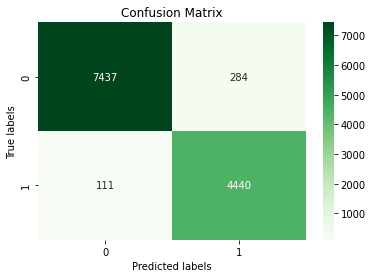

In [147]:
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax , cmap="Greens");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## 10. Working on the test data

In [84]:
#Reading the test data.

offers_test_df = pd.read_parquet('offers_test.parquet')
offers_test_df.head()

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,de,DKNY,beige | Beige,Schal,"{""Marke"": [""DKNY""], ""Gr\u00f6\u00dfenlauf"": [""...",49.990000,https://www.aboutyou.de/p/dkny/schal-7221536,[https://cdn.aboutstatic.com/file/images/d8432...
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,de,MICHAEL Michael Kors,schwarz | Mischfarben,Plisseerock,"{""Marke"": [""MICHAEL Michael Kors""], ""Gr\u00f6\...",79.980000,https://www.aboutyou.de/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/687cd...
2,7dfb8ecf-ba37-42dc-9287-78bac2b0e192,aboutyou,de,MICHAEL Michael Kors,hellbraun | mokka | Braun,Tasche,"{""Zielgruppe"": [""Female""], ""Gr\u00f6\u00dfe (V...",349.000000,https://www.aboutyou.at/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/56cd9...
3,5f42a01e-32e0-4e96-9434-4c2faf4346d1,aboutyou,de,Ragwear,blau | Blau,Winterjacke 'Ashani Puffy',"{""Marke"": [""Ragwear""], ""Zielgruppe"": [""Frauen""...",175.000000,https://www.aboutyou.at/p/ragwear/winterjacke-...,[https://cdn.aboutstatic.com/file/images/56fe6...
4,649b7eeb-30be-4bee-9b45-b01f378ba11a,zalando,de,Samsøe Samsøe,dunkelblau,AVERIE Shorts Stoffhose,main_supplier_code K71977 $ name_suffix sky ca...,129.685455,https://www.zalando.de/lookup/article/SA321S00...,[https://img01.ztat.net/article/93b0febd02a34b...


In [85]:
offers_test_df.shape

(106741, 10)

In [86]:
offers_test_df['shop'].value_counts()

aboutyou    70105
zalando     36636
Name: shop, dtype: int64

In [87]:
#Checking for null values in test set.

offers_test_df.isna().sum()

offer_id        0
shop            0
lang            0
brand           0
color          15
title           0
description     0
price           1
url             0
image_urls     57
dtype: int64

In [88]:
offers_test_df['color']=offers_test_df['color'].fillna('')

In [89]:
print("All NaN values from color removed as you can see.\n")
print(offers_test_df.isna().sum())

All NaN values from color removed as you can see.

offer_id        0
shop            0
lang            0
brand           0
color           0
title           0
description     0
price           1
url             0
image_urls     57
dtype: int64


In [90]:
#NoneType Removal from Test set.

offers_test_df['color'] = offers_test_df['color'].apply(lambda x : none_type_remove(x))
print("All None_type Removed.")

All None_type Removed.


In [91]:
offers_test_df['brand'] = offers_test_df['brand'].apply(lambda x : x.lower())

In [92]:
#Separating offers of the test_data 

offer_zal_test, offer_abtyou_test = get_offers_by_shop(offers_test_df)

In [93]:
offer_zal_test.shape

(36636, 10)

In [94]:
offer_abtyou_test.shape

(70105, 10)

In [95]:
offer_abtyou_test.head()

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,de,dkny,beige | Beige,Schal,"{""Marke"": [""DKNY""], ""Gr\u00f6\u00dfenlauf"": [""...",49.99,https://www.aboutyou.de/p/dkny/schal-7221536,[https://cdn.aboutstatic.com/file/images/d8432...
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,de,michael michael kors,schwarz | Mischfarben,Plisseerock,"{""Marke"": [""MICHAEL Michael Kors""], ""Gr\u00f6\...",79.98,https://www.aboutyou.de/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/687cd...
2,7dfb8ecf-ba37-42dc-9287-78bac2b0e192,aboutyou,de,michael michael kors,hellbraun | mokka | Braun,Tasche,"{""Zielgruppe"": [""Female""], ""Gr\u00f6\u00dfe (V...",349.00,https://www.aboutyou.at/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/56cd9...
3,5f42a01e-32e0-4e96-9434-4c2faf4346d1,aboutyou,de,ragwear,blau | Blau,Winterjacke 'Ashani Puffy',"{""Marke"": [""Ragwear""], ""Zielgruppe"": [""Frauen""...",175.00,https://www.aboutyou.at/p/ragwear/winterjacke-...,[https://cdn.aboutstatic.com/file/images/56fe6...
5,741db6f2-df81-4926-b716-19487dd2cad0,aboutyou,de,modström,khaki | mischfarben | Grün,Sweatshirt 'Holly',"{""Zielgruppe"": [""Female""], ""Material"": [""Sweat...",79.90,https://www.aboutyou.at/p/modstrom/sweatshirt-...,[https://cdn.aboutstatic.com/file/images/4a0cc...


### Text pre-processing for test data.

In [96]:
#Changing the case of brand title and color

offer_zal_test['brand'] = offer_zal_test['brand'].apply(lambda x : x.lower())
offer_abtyou_test['brand'] = offer_abtyou_test['brand'].apply(lambda x : x.lower())

offer_zal_test['title'] = offer_zal_test['title'].apply(lambda x : x.lower())
offer_abtyou_test['title'] = offer_abtyou_test['title'].apply(lambda x : x.lower())

offer_zal_test['color'] = offer_zal_test['color'].apply(lambda x : x.lower())
offer_abtyou_test['color'] = offer_abtyou_test['color'].apply(lambda x : x.lower())

In [99]:
#Repairing the color for aboutyou shop.

offer_abtyou_test['color'] = offer_abtyou_test['color'].apply(lambda x : x.replace(" |", ""))

In [100]:
len(offer_abtyou_test[offer_abtyou_test.brand == 'michael kors'])

1441

In [101]:
offers_test_df.head()

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,de,dkny,beige | Beige,Schal,"{""Marke"": [""DKNY""], ""Gr\u00f6\u00dfenlauf"": [""...",49.990000,https://www.aboutyou.de/p/dkny/schal-7221536,[https://cdn.aboutstatic.com/file/images/d8432...
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,de,michael michael kors,schwarz | Mischfarben,Plisseerock,"{""Marke"": [""MICHAEL Michael Kors""], ""Gr\u00f6\...",79.980000,https://www.aboutyou.de/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/687cd...
2,7dfb8ecf-ba37-42dc-9287-78bac2b0e192,aboutyou,de,michael michael kors,hellbraun | mokka | Braun,Tasche,"{""Zielgruppe"": [""Female""], ""Gr\u00f6\u00dfe (V...",349.000000,https://www.aboutyou.at/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/56cd9...
3,5f42a01e-32e0-4e96-9434-4c2faf4346d1,aboutyou,de,ragwear,blau | Blau,Winterjacke 'Ashani Puffy',"{""Marke"": [""Ragwear""], ""Zielgruppe"": [""Frauen""...",175.000000,https://www.aboutyou.at/p/ragwear/winterjacke-...,[https://cdn.aboutstatic.com/file/images/56fe6...
4,649b7eeb-30be-4bee-9b45-b01f378ba11a,zalando,de,samsøe samsøe,dunkelblau,AVERIE Shorts Stoffhose,main_supplier_code K71977 $ name_suffix sky ca...,129.685455,https://www.zalando.de/lookup/article/SA321S00...,[https://img01.ztat.net/article/93b0febd02a34b...


In [102]:
#Getting unique brands from test data.

brand_list_test = offers_test_df['brand'].unique()
print("Total Unique Brands in test set:",len(brand_list_test))

Total Unique Brands in test set: 122


In [103]:
#Getting unique brands for zalando.

test_offer_by_brand = get_shops_for_brand(offers_test_df,brand_list_test) #Dictionary resembling the map of brand and shop.
print("Total Unique Zalando Brands in test set:",len(test_offer_by_brand['zalando']))

Total Unique Zalando Brands in test set: 89


In [104]:
#Getting unique brands for aboutoyu.

print("Total Unique Zalando Brands in test set:",len(test_offer_by_brand['aboutyou']))

Total Unique Zalando Brands in test set: 111


In [106]:
#Getting the common brands in both shop for test set.

common_brands_test = []
for brand in brand_list_test:
    if brand in test_offer_by_brand['zalando'] and brand in test_offer_by_brand['aboutyou']:
        common_brands_test.append(brand)

In [107]:
len(common_brands_test)

78

In [108]:
#Merging the two shop pffers for test set

data2 = pd.merge(offer_zal_test,offer_abtyou_test, on=['color','brand'])

In [109]:
offer_abtyou_test=offer_abtyou_test.set_index('offer_id')

In [111]:
#Getting the color for aboutyou shop. 

aboutyou_test_color = []
for i in data2['offer_id_y']:
    for ids in offer_abtyou_test.index:
        if i == ids:
            aboutyou_test_color.append(offer_abtyou_test.loc[ids]['color'])

# data2['color_y']=data2['color'] 
# data2['title_y']=data2['title']

In [112]:
data2['aboutyou_color']=aboutyou_test_color

In [113]:
data2.head()

,offer_id_x,shop_x,lang_x,brand,color,title_x,description_x,price_x,url_x,image_urls_x,offer_id_y,shop_y,lang_y,title_y,description_y,price_y,url_y,image_urls_y,aboutyou_color
0,5547d05e-620a-4a4a-8cd9-2fd6bda5b737,zalando,de,luvia cosmetics,schwarz,vegan signature brush set pinsel-set,main_supplier_code K88101 $ name_suffix - $ co...,39.867273,https://www.zalando.de/lookup/article/LUI31J00...,[https://img01.ztat.net/article/97c87a4e10e34f...,f8980475-3d94-48ae-978c-16f77f50d7be,aboutyou,de,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",34.9,https://www.aboutyou.de/p/luvia-cosmetics/kabu...,[https://cdn.aboutstatic.com/file/b6836c156106...,schwarz
1,ec93b1f5-2147-44da-83f3-0c1dcc0ebfb7,zalando,de,luvia cosmetics,schwarz,foundation brush make-up-pinsel,main_supplier_code K88101 $ name_suffix - $ co...,13.958182,https://www.zalando.de/lookup/article/LUI31J00...,[https://img01.ztat.net/article/bad87643135a41...,f8980475-3d94-48ae-978c-16f77f50d7be,aboutyou,de,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",34.9,https://www.aboutyou.de/p/luvia-cosmetics/kabu...,[https://cdn.aboutstatic.com/file/b6836c156106...,schwarz
2,7749438b-97a0-47ac-ba83-926083e0069f,zalando,de,luvia cosmetics,schwarz,classic contour make-up-pinsel,main_supplier_code K88101 $ name_suffix black ...,10.958182,https://www.zalando.de/lookup/article/LUI31J00...,[https://img01.ztat.net/article/48bd5cd10be440...,f8980475-3d94-48ae-978c-16f77f50d7be,aboutyou,de,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",34.9,https://www.aboutyou.de/p/luvia-cosmetics/kabu...,[https://cdn.aboutstatic.com/file/b6836c156106...,schwarz
3,2d5a2ec8-73f6-45dd-a32a-779ef48d82fe,zalando,de,luvia cosmetics,schwarz,eye shader brush lidschattenpinsel,main_supplier_code K88101 $ name_suffix - $ co...,8.958182,https://www.zalando.de/lookup/article/LUI31J00...,[https://img01.ztat.net/article/63f4d805226547...,f8980475-3d94-48ae-978c-16f77f50d7be,aboutyou,de,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",34.9,https://www.aboutyou.de/p/luvia-cosmetics/kabu...,[https://cdn.aboutstatic.com/file/b6836c156106...,schwarz
4,07a1a805-8a2d-4e5b-8981-be5118d841ed,zalando,de,luvia cosmetics,schwarz,foundation brush make-up-pinsel,main_supplier_code K88101 $ name_suffix black ...,9.958182,https://www.zalando.de/lookup/article/LUI31J01...,[https://img01.ztat.net/article/66a6b22557fc42...,f8980475-3d94-48ae-978c-16f77f50d7be,aboutyou,de,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",34.9,https://www.aboutyou.de/p/luvia-cosmetics/kabu...,[https://cdn.aboutstatic.com/file/b6836c156106...,schwarz


In [116]:
#Dropping the unecessary columns

data2 = data2.drop(['image_urls_y','url_y','lang_x','shop_x','brand','shop_y' ,'lang_y','price_y','image_urls_x','url_x','price_x'],axis=1)
# final_test_data = data.drop(['zalando_color','zalando_title','zalando_description','aboutyou_color','aboutyou_title','aboutyou_description'],axis=1)

In [118]:
#Renaming the columns.

final_test_data=data2.rename(
    columns={'offer_id_x':'zalando','offer_id_y':'aboutyou',
             'color':'zalando_color', 'title_y':'aboutyou_title',
             'title_x':'zalando_title','color_y':'aboutyou_color',
             'description_x':'zalando_description','description_y':'aboutyou_description'})

In [119]:
final_test_data.head()

,zalando,zalando_color,zalando_title,zalando_description,aboutyou,aboutyou_title,aboutyou_description,aboutyou_color
0,5547d05e-620a-4a4a-8cd9-2fd6bda5b737,schwarz,vegan signature brush set pinsel-set,main_supplier_code K88101 $ name_suffix - $ co...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",schwarz
1,ec93b1f5-2147-44da-83f3-0c1dcc0ebfb7,schwarz,foundation brush make-up-pinsel,main_supplier_code K88101 $ name_suffix - $ co...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",schwarz
2,7749438b-97a0-47ac-ba83-926083e0069f,schwarz,classic contour make-up-pinsel,main_supplier_code K88101 $ name_suffix black ...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",schwarz
3,2d5a2ec8-73f6-45dd-a32a-779ef48d82fe,schwarz,eye shader brush lidschattenpinsel,main_supplier_code K88101 $ name_suffix - $ co...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",schwarz
4,07a1a805-8a2d-4e5b-8981-be5118d841ed,schwarz,foundation brush make-up-pinsel,main_supplier_code K88101 $ name_suffix black ...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""Detailfarbe"": [""schwarz""], ""Ordersaison"": [""...",schwarz


### Measuring Similarities for test set

In [120]:
#Calculating the color similarity.

final_test_data = engineer_features_color(final_test_data)

In [121]:
#Calculating the title similarity.

final_test_data = engineer_features_title(final_test_data)

In [122]:
#Calculating the description similarity.

final_test_data = engineer_features_description(final_test_data)

In [123]:
final_test_data.head()

,zalando,zalando_color,zalando_title,zalando_description,aboutyou,aboutyou_title,aboutyou_description,aboutyou_color,color_levenshtein_distance,color_damerau_levenshtein_distance,...,description_partial_ratio,description_token_sort_ratio,description_token_set_ratio,description_w_ratio,description_uq_ratio,description_q_ratio,description_matching_numbers,description_matching_numbers_log,description_log_fuzz_score,description_log_fuzz_score_numbers
0,5547d05e-620a-4a4a-8cd9-2fd6bda5b737,schwarz,vegan signature brush set pinsel-set,main_supplier_code k88101 $ name_suffix - $ co...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""detailfarbe"": [""schwarz""], ""ordersaison"": [""...",schwarz,0,0,...,4,1,16,86,1,1,0.111111,0.105361,3.091042,0.893818
1,ec93b1f5-2147-44da-83f3-0c1dcc0ebfb7,schwarz,foundation brush make-up-pinsel,main_supplier_code k88101 $ name_suffix - $ co...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""detailfarbe"": [""schwarz""], ""ordersaison"": [""...",schwarz,0,0,...,6,1,20,86,1,1,0.100000,0.095310,3.332205,1.029619
2,7749438b-97a0-47ac-ba83-926083e0069f,schwarz,classic contour make-up-pinsel,main_supplier_code k88101 $ name_suffix black ...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""detailfarbe"": [""schwarz""], ""ordersaison"": [""...",schwarz,0,0,...,6,1,18,86,1,1,0.100000,0.095310,3.258097,0.955511
3,2d5a2ec8-73f6-45dd-a32a-779ef48d82fe,schwarz,eye shader brush lidschattenpinsel,main_supplier_code k88101 $ name_suffix - $ co...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""detailfarbe"": [""schwarz""], ""ordersaison"": [""...",schwarz,0,0,...,4,1,17,86,1,1,0.100000,0.095310,3.135494,0.832909
4,07a1a805-8a2d-4e5b-8981-be5118d841ed,schwarz,foundation brush make-up-pinsel,main_supplier_code k88101 $ name_suffix black ...,f8980475-3d94-48ae-978c-16f77f50d7be,kabukipinsel 'the essential kabuki',"{""detailfarbe"": [""schwarz""], ""ordersaison"": [""...",schwarz,0,0,...,6,1,20,86,1,1,0.100000,0.095310,3.332205,1.029619


In [124]:
#Preparing the input data for prediction using the model.

final_test_similarity = final_test_data.drop(['zalando_color','zalando_title','zalando_description','aboutyou_color','aboutyou_title','aboutyou_description'],axis=1)

final_test_similarity.head()

,zalando,aboutyou,color_levenshtein_distance,color_damerau_levenshtein_distance,color_hamming_distance,color_jaro_similarity,color_jaro_winkler_similarity,color_match_rating_comparison,color_fuzz_ratio,color_partial_ratio,...,description_partial_ratio,description_token_sort_ratio,description_token_set_ratio,description_w_ratio,description_uq_ratio,description_q_ratio,description_matching_numbers,description_matching_numbers_log,description_log_fuzz_score,description_log_fuzz_score_numbers
0,5547d05e-620a-4a4a-8cd9-2fd6bda5b737,f8980475-3d94-48ae-978c-16f77f50d7be,0,0,0,1.0,1.0,1,100,100,...,4,1,16,86,1,1,0.111111,0.105361,3.091042,0.893818
1,ec93b1f5-2147-44da-83f3-0c1dcc0ebfb7,f8980475-3d94-48ae-978c-16f77f50d7be,0,0,0,1.0,1.0,1,100,100,...,6,1,20,86,1,1,0.100000,0.095310,3.332205,1.029619
2,7749438b-97a0-47ac-ba83-926083e0069f,f8980475-3d94-48ae-978c-16f77f50d7be,0,0,0,1.0,1.0,1,100,100,...,6,1,18,86,1,1,0.100000,0.095310,3.258097,0.955511
3,2d5a2ec8-73f6-45dd-a32a-779ef48d82fe,f8980475-3d94-48ae-978c-16f77f50d7be,0,0,0,1.0,1.0,1,100,100,...,4,1,17,86,1,1,0.100000,0.095310,3.135494,0.832909
4,07a1a805-8a2d-4e5b-8981-be5118d841ed,f8980475-3d94-48ae-978c-16f77f50d7be,0,0,0,1.0,1.0,1,100,100,...,6,1,20,86,1,1,0.100000,0.095310,3.332205,1.029619


## Test Predictions 

In [125]:
test_predictions = final_test_similarity.drop(['color_matching_numbers','color_matching_numbers_log','zalando','aboutyou'],axis=1)

In [126]:
#Predicting the match for the test data using XGBoost Classifier

test_predictions = list(model.predict(test_predictions))

In [127]:
final_test_matches = pd.DataFrame()

In [128]:
final_test_matches['zalando'] = final_test_data['zalando']
final_test_matches['aboutyou'] = final_test_data['aboutyou']

In [129]:
final_test_matches['match']=test_predictions

In [130]:
final_test_matches['match'].value_counts()

1    12740
0       34
Name: match, dtype: int64

In [131]:
#Just tetting only the matches in the test set that are predicted.

final_test_matches = final_test_matches[final_test_matches['match']==1]

In [132]:
final_test_matches.tail(50)

,zalando,aboutyou,match
12724,1ea5ad7c-c1d0-4649-8d7b-00c09e1429ac,cfe6aea5-8923-4c11-83a9-3a0a49a44782,1
12725,b1d4930d-9253-4023-8aa1-afdcc799cd2e,cfe6aea5-8923-4c11-83a9-3a0a49a44782,1
12726,b522c390-7af1-49e2-b31d-20b5be85351d,cfe6aea5-8923-4c11-83a9-3a0a49a44782,1
12727,f8a24856-865f-437c-8d0d-1d5c7bf05eb4,cfe6aea5-8923-4c11-83a9-3a0a49a44782,1
12728,67fd99ca-35b8-4abd-98aa-21fb139e241b,16db0beb-1ca9-43b7-a4b6-576830e6f9b8,1
12729,67fd99ca-35b8-4abd-98aa-21fb139e241b,bb2f86db-8877-4a91-9c6d-e3a8f1bfb36d,1
12730,3742515e-e097-4ce1-a943-2675bb9351b4,16db0beb-1ca9-43b7-a4b6-576830e6f9b8,1
12731,3742515e-e097-4ce1-a943-2675bb9351b4,bb2f86db-8877-4a91-9c6d-e3a8f1bfb36d,1
12732,da24a139-d8c9-456f-85e5-424f8d28318b,16db0beb-1ca9-43b7-a4b6-576830e6f9b8,1
12733,da24a139-d8c9-456f-85e5-424f8d28318b,bb2f86db-8877-4a91-9c6d-e3a8f1bfb36d,1


In [133]:
final_test_matches['match'].value_counts()

1    12740
Name: match, dtype: int64

### Verrifying the final test data  matches by plotting the images.

In [134]:
offer_zal_test = offer_zal_test.set_index('offer_id')

In [135]:
offer_zal_test.loc['f8a24856-865f-437c-8d0d-1d5c7bf05eb4']['url']

'https://www.zalando.de/lookup/article/NY631E04F-E11'

In [137]:
offer_abtyou_test.loc['cfe6aea5-8923-4c11-83a9-3a0a49a44782']['url']

'https://www.aboutyou.de/p/nyx-professional-makeup/total-control-pro-hue-shifter-7054796'

In [138]:
#Function for plotting zalando images 

def plot_images_zal(product):
    
    # Data
    images = offer_zal_test.loc[product]['image_urls']
    
    # Plot it!
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12, 4), dpi=100)
    print(f"Zalando: {offer_zal_test.loc[product]['title']} {offer_zal_test.loc[product]['color']}")

    
    if len(images) > 1:     
        axes = axes.flatten()
        for i, axis in enumerate(axes):
            url = images[i]
            image = np.array(Image.open(urllib.request.urlopen(url)))
            axis.imshow(image)
            axis.axis('off')
    else:
        url = images[0]
        image = np.array(Image.open(urllib.request.urlopen(url)))
        axes.imshow(image)
        axes.axis('off')

    fig.tight_layout()
    plt.show()

In [139]:
#Function for plotting Aboutyou images 


def plot_images_abtyou(product):
    
    # Data
    images = offer_abtyou_test.loc[product]['image_urls']
    
    # Plot it!
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12, 4), dpi=100)
    print(f"Aboutyou: {offer_abtyou_test.loc[product]['title']} {offer_abtyou_test.loc[product]['color']}")
    
    if len(images) > 1:     
        axes = axes.flatten()
        for i, axis in enumerate(axes):
            url = images[i]
            image = np.array(Image.open(urllib.request.urlopen(url)))
            axis.imshow(image)
            axis.axis('off')
    else:
        url = images[0]
        image = np.array(Image.open(urllib.request.urlopen(url)))
        axes.imshow(image)
        axes.axis('off')

    fig.tight_layout()
    plt.show()

In [142]:
final_matches_test_eval = final_test_matches.drop(['match'],axis=1)
final_matches_test_eval.tail(2000)

,zalando,aboutyou
10767,a87e09b2-a765-4cb9-92ad-10f3fbc99fa0,a7f393b3-521a-4b4c-94af-36410e955c6d
10768,a87e09b2-a765-4cb9-92ad-10f3fbc99fa0,e99d02d9-2fec-45e7-a4f5-2760c8df4622
10769,a87e09b2-a765-4cb9-92ad-10f3fbc99fa0,926049f8-6ee3-450d-b978-5f3bdff8759b
10770,a87e09b2-a765-4cb9-92ad-10f3fbc99fa0,7c5131d3-0a9e-4b31-8f3a-f5874cfabde0
10771,a87e09b2-a765-4cb9-92ad-10f3fbc99fa0,957c7748-befa-4257-8e90-9dcfa44e25a8
...,...,...
12769,1a66a896-41dc-4a34-9e7a-2ad588d1c00b,8734e681-a6c2-4771-81df-3c570b5a785d
12770,c537bb29-9a96-4a04-8c34-679cc4628f91,31d85d9f-41bc-4e0f-93f8-585984e29ef1
12771,4e265b8d-98c0-4642-a834-ee46549f8aad,31d85d9f-41bc-4e0f-93f8-585984e29ef1
12772,96f86972-2174-4e07-946d-66a4c574d480,1bbd5b4b-1f6f-4350-a3f1-850ac7f10ba8


In [143]:
predicted_match = final_matches_test_eval.iloc[27]
predicted_match

zalando     c5ea9d10-89a0-49ee-9a98-3739bf3e786d
aboutyou    f8980475-3d94-48ae-978c-16f77f50d7be
Name: 27, dtype: object

In [144]:
offer_zal_test.loc['61120c1d-912c-4c8f-82f8-d59557bf5105']

shop                                                     zalando
lang                                                          de
brand                                            luvia cosmetics
color                                                    schwarz
title                               contour brush make-up-pinsel
description    main_supplier_code K88101 $ name_suffix - $ co...
price                                                  13.958182
url            https://www.zalando.de/lookup/article/LUI31J00...
image_urls     [https://img01.ztat.net/article/f16e03d893ae4f...
Name: 61120c1d-912c-4c8f-82f8-d59557bf5105, dtype: object

Zalando: lift & snatch brow tint pen augenbrauenstift braun


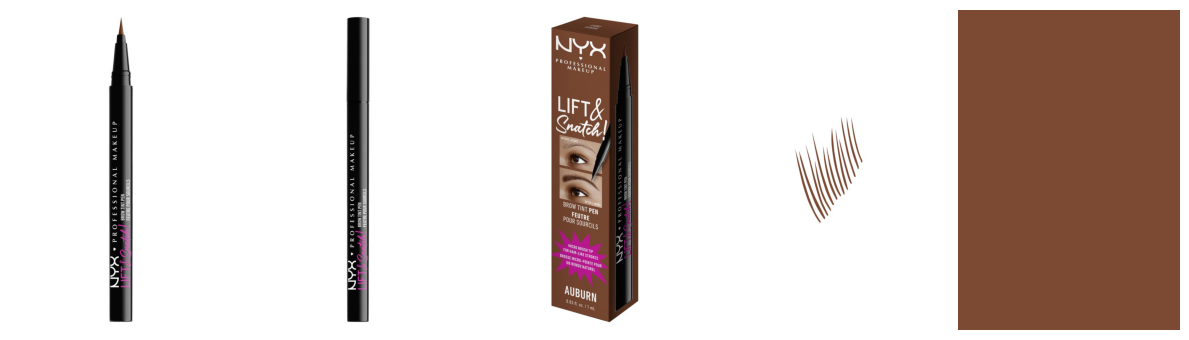

In [145]:
plot_images_zal(final_matches_test_eval['zalando'][6088])

Aboutyou: micro brow pencil braun


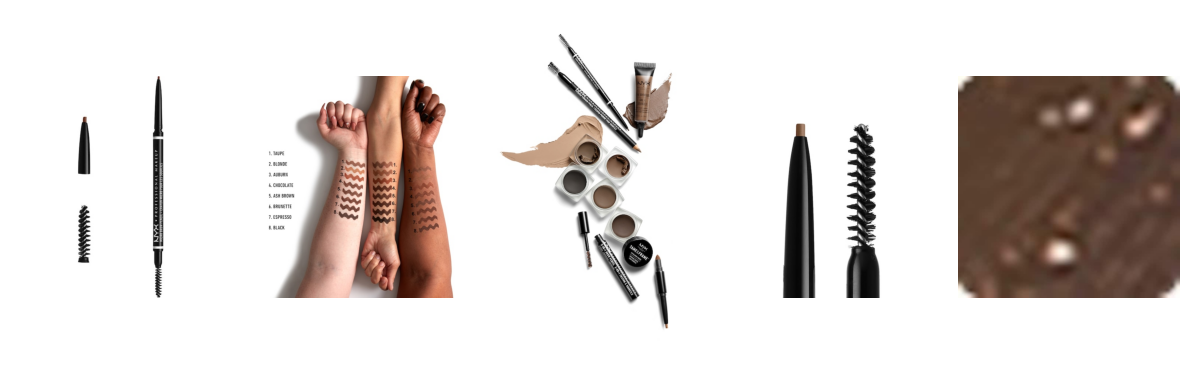

In [146]:
plot_images_abtyou(final_matches_test_eval['aboutyou'][6088])

## Saving the test data

In [148]:
final_matches_test_eval.to_parquet( 'matches_test_predicted.parquet' )

### The End